In [27]:
import pandas as pd
import numpy as np

In [28]:
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from numpy.random import RandomState

In [29]:
sklearn.__version__

'0.19.1'

In [30]:
def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None ):
    if autoscale:
        x_scale=model.feature_importances_.max()+headroom
    else:
        x_scale=1
    feature_dict=dict(zip(feature_names,model.feature_importances_))
    
    for col_name in summarized_columns:
        sum_value = sum(x for i,x in feature_dict.items() if col_name in i)
        keys_to_remove=[i for i in feature_dict.keys() if col_name in i]
        for i in keys_to_remove:
            feature_dict.pop(i)
        feature_dict[col_name]=sum_value
    
    results=pd.Series(list(feature_dict.values()),index=feature_dict.keys())
    results=results.sort_values(axis=0)
    results.plot(kind='barh', figsize=(width,len(results)/2), xlim=(0,x_scale))

In [31]:
def DropColumns(x,ls=None):
    '''Drop the columns that are determined to have no useful information for the task, based on domain knowledge'''
    
    if ls is None:
        del_var=['dateCrawled', 'name', 'offerType', 'abtest', 'monthOfRegistration', 
         'brand', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen']
        x=x.drop(labels=del_var,axis=1)
    else:
        x=x.drop(labels=ls,axis=1)
    
    return x

In [32]:
def RemoveOutlier(x,price_start,price_end,year_start,year_end,powerPS_start,powerPS_end):
    '''remove outlier by EDA and Domain Knowledge'''
    
    x=x[(x['price']>price_start) & (x['price']<price_end)&
                (x['yearOfRegistration']>year_start) & (x['yearOfRegistration']<year_end)&
                (x['powerPS']>powerPS_start)&(x['powerPS']<powerPS_end)]
    return x

In [33]:
def FillMissing(x):
    '''fill missing value for both categorical and numeric variables'''
    categorical= x.columns[x.dtypes==object]
    numeric=x.columns[x.dtypes=='int64']
    
    #replace missing value in cate
    for i in categorical:
        x[i].replace(np.nan,'notDeclared',inplace=True)
        
    #replace missing value in numeric
    for i in numeric:
        x[i].replace(np.nan,x[i].mean(),inplace=True)
    
    return x
        

In [34]:
def CombiningCarModels(x,model_threshold):
    '''input the desired threshold and combine the car models based on the threshold'''
    other_list=[]
    s=x['model'].value_counts()
    for i in list(s.index):
        if s[i]<model_threshold:
            other_list.append(i)
    x['model'].replace(other_list,'Other',inplace=True)

    return x
    
    
    

In [35]:
def TransformTest(test,train,price_start,price_end,year_start,year_end,powerPS_start,powerPS_end,model_threshold):
    #n=len(test['price'])
    test=DropColumns(test)
    test=RemoveOutlier(test,price_start,price_end,year_start,year_end,powerPS_start,powerPS_end)
    test=FillMissing(test)
    test=CombiningCarModels(test,model_threshold)
    test=pd.get_dummies(test,columns=list(test.select_dtypes(include=['object']).columns))
    for i in train.columns:
        if i not in test.columns:
            test[i]=pd.Series([0 for x in range(len(test['price']))],index=test.index)
    return test

In [36]:
################################
#data preparing

In [37]:
used_cars=pd.read_csv('autos.csv',encoding='latin-1')

In [38]:
#split the dataset into training and testing 70% vs 30%
RS1=RandomState(1)
msk1=RS1.rand(len(used_cars['name']))<=0.7
train=used_cars.iloc[msk1]
test=used_cars.iloc[~msk1]

In [39]:
#####################################################
#####################################################
#build a baseline model with the training and testing

In [40]:
base_train=train.select_dtypes(include=['int64'])
base_test=test.select_dtypes(include=['int64'])

In [41]:
base_train_x=base_train.drop('price',axis=1)
base_train_y=base_train['price']
base_test_x=base_test.drop('price',axis=1)
base_test_y=base_test['price']

In [42]:
lr_base=linear_model.LinearRegression()
lr_base.fit(base_train_x,base_train_y)
base_pred_y=lr_base.predict(base_test_x)
base_mae=mean_absolute_error(base_test_y,base_pred_y)

In [43]:
base_mae

29426.573146846615

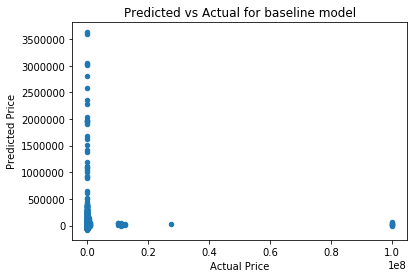

In [44]:
plt.figure()
plt.scatter(base_test_y,base_pred_y,s=20)
plt.title('Predicted vs Actual for baseline model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.savefig('Predicted vs Actual Price')
plt.show()

In [45]:
##############################
#############################
#feature engineering on train

In [46]:
train=DropColumns(train)
train=RemoveOutlier(train,100,150000,1950,2017,10,500)
train=FillMissing(train)
train=CombiningCarModels(train,100)

In [47]:
#a list of categorical variable after feature engineering
#reserve a list of all categorical variable of train after engineering and before get_dummies
cat= train.columns[train.dtypes==object]

In [48]:
####check if the transform is successful:

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217087 entries, 2 to 371527
Data columns (total 10 columns):
seller                217087 non-null object
price                 217087 non-null int64
vehicleType           217087 non-null object
yearOfRegistration    217087 non-null int64
gearbox               217087 non-null object
powerPS               217087 non-null int64
model                 217087 non-null object
kilometer             217087 non-null int64
fuelType              217087 non-null object
notRepairedDamage     217087 non-null object
dtypes: int64(4), object(6)
memory usage: 18.2+ MB


In [50]:
##check categorical variable:
for i in cat:
    print(i,' has {} unique categories'.format(len(set(train[i]))))

seller  has 2 unique categories
vehicleType  has 9 unique categories
gearbox  has 3 unique categories
model  has 193 unique categories
fuelType  has 8 unique categories
notRepairedDamage  has 3 unique categories


In [51]:
train.isnull().sum()

seller                0
price                 0
vehicleType           0
yearOfRegistration    0
gearbox               0
powerPS               0
model                 0
kilometer             0
fuelType              0
notRepairedDamage     0
dtype: int64

In [52]:
#one-hot encoding
train=pd.get_dummies(train,columns=cat)

In [53]:
###################################
###################################
#gridsearch on different algorithms

In [54]:
#seperate features and labels in training set
x_train=train.drop('price',axis=1)
y_train=train['price']


In [55]:
#only use 70% of the training data to do the gridsearch

msk2=np.random.rand(len(x_train))<=0.7
gridsearch_features=x_train[msk2]
gridsearch_labels=y_train[msk2]

validate_features=x_train[~msk2]
validate_labels=y_train[~msk2]

In [82]:
#Linear Regression: Ridge & Lasso

In [31]:
#Ridge
%%time
lr_ridge=linear_model.Ridge(solver='sag') #alpho=0 correspond to ordinary least square (ordinary lr)
lr_ridge_parameters={'alpha':[0, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]}
regressor_lr_ridge=GridSearchCV(lr_ridge,lr_ridge_parameters)
regressor_lr_ridge.fit(gridsearch_features,gridsearch_labels)



CPU times: user 13min 28s, sys: 16.5 s, total: 13min 45s
Wall time: 13min 40s


In [36]:
#joblib.dump(regressor_lr_ridge,'regressor_lr_ridge2')

['regressor_lr_ridge2']

In [25]:
regressor_lr_ridge=joblib.load('regressor_lr_ridge2')

/Users/zhe/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator Ridge from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/zhe/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


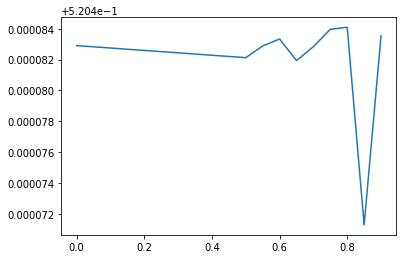

In [119]:
#plot learning curve
plt.figure()
test_scores=regressor_lr_ridge.cv_results_['mean_test_score']
plt.plot([0, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9],test_scores)
plt.savefig('ridge_LearninCurve')
plt.show()

In [26]:
regressor_lr_ridge.best_params_

{'alpha': 0.8}

In [84]:
#lasso
%%time 
#does not advise to use alpha=0
lr_lasso=linear_model.Lasso(max_iter=20000)
lr_lasso_parameters={'normalize':[True,False],
              'alpha':[0.02, 0.03, 0.04, 0.05,0.1, 0.5, 1, 1.5]}
regressor_lr_lasso=GridSearchCV(lr_lasso,lr_lasso_parameters)
regressor_lr_lasso.fit(gridsearch_features,gridsearch_labels)

CPU times: user 54min 50s, sys: 25 s, total: 55min 15s
Wall time: 1h 47min 8s


In [22]:
regressor_lr_lasso=joblib.load('regressor_lr_lasso2')

/Users/zhe/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator Lasso from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/zhe/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
#joblib.dump(regressor_lr_lasso,'regressor_lr_lasso2')

In [80]:
regressor_lr_lasso.best_params_

{'alpha': 0.04, 'normalize': False}

In [110]:
lasso_test_scores=[regressor_lr_lasso.cv_results_['mean_test_score'][i] for i in range(16)  if i%2 !=0 ]

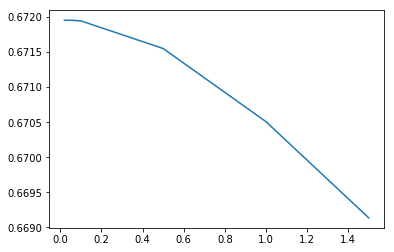

In [113]:
#plot 'learning curve'
plt.figure()
test_scores=regressor_lr_lasso.cv_results_['mean_test_score']
plt.plot([0.02, 0.03, 0.04, 0.05,0.1, 0.5, 1, 1.5],lasso_test_scores)
plt.savefig('lasso_LearninCurve')
plt.show()

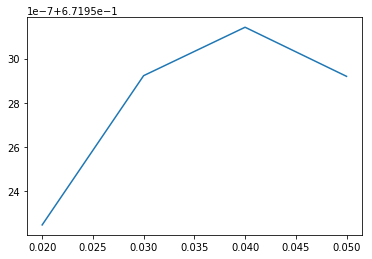

In [114]:
plt.figure()
test_scores=regressor_lr_lasso.cv_results_['mean_test_score']
plt.plot([0.02, 0.03, 0.04, 0.05],lasso_test_scores[:4])
plt.savefig('lasso_LearninCurve_zoomin')
plt.show()

In [28]:
#RandomForestRegressor

In [ ]:
%%time
rfr=RandomForestRegressor()
parameters={'n_estimators':[10, 50, 100, 110, 120, 130, 140, 150, 200, 300, 400, 500] }
regressor_rfr=GridSearchCV(rfr,parameters)
regressor_rfr.fit(gridsearch_features,gridsearch_labels)

In [ ]:
#joblib.dump(regressor_rfr,'regressor_rfr2')

In [12]:
regressor_rfr=joblib.load('regressor_rfr2.')

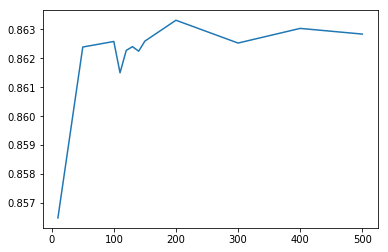

In [13]:
#plot 'learning curve'
plt.figure()
test_scores=regressor_rfr.cv_results_['mean_test_score']
plt.plot([10, 50, 100, 110, 120, 130, 140, 150, 200, 300, 400, 500],test_scores)
plt.savefig('RandomForest_LearninCurve')
plt.show()

In [14]:
regressor_rfr.best_params_

{'n_estimators': 200}

In [33]:
# DecisionTree regressor: 

In [86]:
# DecisionTree regressor: 
dtr=DecisionTreeRegressor()
min_samples_split_values=list(map(int,np.linspace(2,3002,11)))
min_samples_leaf_values=list(map(int,np.linspace(1,3001,11)))


dtr_parameters={'min_samples_split':min_samples_split_values,
           'min_samples_leaf':min_samples_leaf_values,
           'max_depth':[None, 5, 10, 15, 20, 25]}



In [87]:
%%time
regressor_dt=GridSearchCV(dtr,dtr_parameters)
regressor_dt.fit(gridsearch_features,gridsearch_labels)

CPU times: user 32min 44s, sys: 7min 1s, total: 39min 45s
Wall time: 2h 1min 17s


In [88]:
#joblib.dump(regressor_dt,'regressor_dt2')

['regressor_dt2']

In [20]:
regressor_dt=joblib.load('regressor_dt2')

/Users/zhe/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/zhe/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [21]:
regressor_dt.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 302}

In [91]:
#KNeighborsRegressor 
KNR=KNeighborsRegressor()
KNR_parameters={'n_neighbors':[2,5,10,15,30],'p':[1,2]}

In [92]:
%%time
regressor_KNR=GridSearchCV(KNR,KNR_parameters)
regressor_KNR.fit(gridsearch_features,gridsearch_labels)

CPU times: user 43min 45s, sys: 16.6 s, total: 44min 1s
Wall time: 1h 3min 47s


In [93]:
#joblib.dump(regressor_KNR,'regressor_KNR2')

['regressor_KNR2']

In [16]:
regressor_KNR=joblib.load('regressor_KNR2')

/Users/zhe/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/zhe/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [120]:
KNR_test_scores=[regressor_KNR.cv_results_['mean_test_score'][i] for i in range(10)  if i%2 !=0 ]

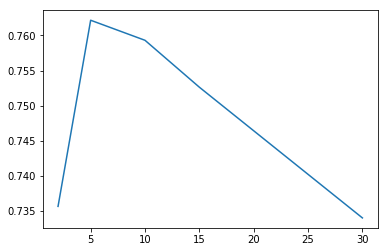

In [121]:
plt.figure()
plt.plot([2,5,10,15,30],KNR_test_scores)
plt.savefig('KNR_LearninCurve')
plt.show()

In [17]:
regressor_KNR.best_params_

{'n_neighbors': 5, 'p': 1}

In [ ]:
###################################
###################################
#compare different algorithms

In [56]:
%%time
lr_ridge_best=linear_model.Ridge(solver='sag', alpha= 0.8)
lr_lasso_best=linear_model.Lasso(max_iter=20000, alpha= 0.04, normalize= False)
rfr_best=RandomForestRegressor(n_estimators= 200)
dtr_best=DecisionTreeRegressor(max_depth= None, min_samples_leaf= 1, min_samples_split= 302)
KNR_best=KNeighborsRegressor(n_neighbors= 5, p= 1)
model_ls=[lr_ridge_best, lr_lasso_best, rfr_best, dtr_best, KNR_best]
mae_ls=[]
for model in model_ls:
    model.fit(gridsearch_features,gridsearch_labels)
    label_pred=model.predict(validate_features)
    mae=mean_absolute_error(validate_labels,label_pred)
    mae_ls.append(mae)

CPU times: user 10min 49s, sys: 3.63 s, total: 10min 52s
Wall time: 3h 1min 8s


In [77]:
#joblib.dump(mae_ls,'mae_ls')

['mae_ls']

In [78]:
mae_ls=joblib.load('mae_ls')

In [76]:
#mae_ls

[3326.3581806850852,
 2645.1739944034757,
 1257.1436050826599,
 1628.0181795322319,
 1537.1582216602155]

In [57]:
#Select RandomForest as the best algorithm for our task, para:300 estimators

In [58]:
test=TransformTest(test,train,100,150000,1950,2017,10,500,100)

In [59]:
#seperate features and labels in test set
x_test=test.drop('price',axis=1)
y_test=test['price']

In [60]:
%%time
#build the final model
final_model=RandomForestRegressor(n_estimators= 200)
final_model.fit(x_train,y_train)

CPU times: user 10min 34s, sys: 2.52 s, total: 10min 37s
Wall time: 1h 18min 19s


In [61]:
final_model_pred=final_model.predict(x_test)
final_model_mae=mean_absolute_error(y_test,final_model_pred)

In [62]:
print('final model (RandomForestRegressor) result: ')
print('mean_absolute_error is: ',final_model_mae)

final model (RandomForestRegressor) result: 
mean_absolute_error is:  1834.92271705


In [75]:
joblib.dump(final_model,'final_model_RS1')

['final_model_RS1']

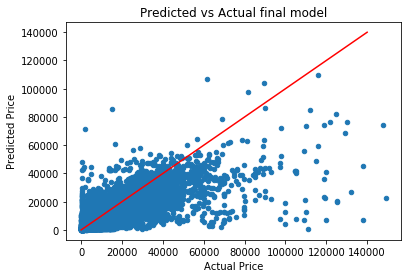

In [64]:
#visualizd result:
#graph1: final model
plt.figure()
plt.scatter(y_test,final_model_pred,s=20)
plt.plot([0,140000],[0,140000],c='red')
plt.title('Predicted vs Actual final model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.savefig('Predicted vs Actual final model')

plt.show()

In [65]:
#plot feature importance graph for final model

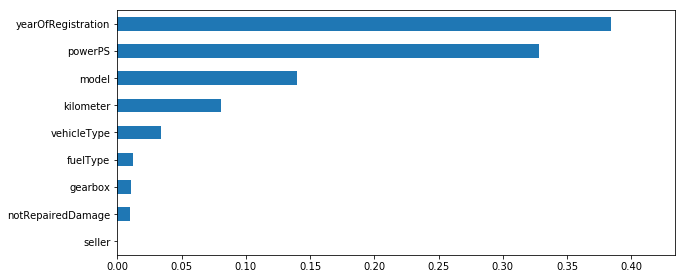

In [66]:
col_names=x_train.columns.values
#col_names
categorical_variable=list(cat)
#cat_list
graph_feature_importances(final_model, col_names, summarized_columns=categorical_variable)
plt.savefig('feature_importance of final model')
plt.show()

In [67]:
#experiment the subset of features as suggest by the feature importance graph

In [68]:
subset_model=RandomForestRegressor(n_estimators= 200)

In [69]:
x_subset_train=x_train.drop(['seller_gewerblich','seller_privat'],axis=1)
y_subset_train=y_train
x_subset_test=x_test.drop(['seller_privat','seller_gewerblich'],axis=1)

In [70]:
subset_model.fit(x_subset_train,y_subset_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
subset_model_pred=subset_model.predict(x_subset_test)

In [72]:
subset_model_mae=mean_absolute_error(y_test,subset_model_pred)

In [73]:
subset_model_mae

1833.9575355709467

In [74]:
joblib.dump(subset_model,'subset_model')

['subset_model']

In [ ]:
#after selecting subset, mae even go down a little